In [177]:
#Basic shit
import re
import numpy as np
import random
import time
from datetime import datetime, timedelta
import math
from IPython.display import Image


#Dataframes + read data
import pickle
import json 
import geojson
import geocoder

import pandas as pd      #Package for handling large data structures
import geopandas as gpd  #http://localhost:8888/notebooks/KTH/GitHub/DF23_cycle/M_stat_all.ipynb#Package for handling geospatial data
from geopandas import GeoDataFrame, read_file
from pyproj import CRS   #coordinate reference system

#Shapes
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, shape
from shapely import wkt  #If the geo_data is in wkt-format, this package is needed to "read" that (wtk - well known text)
import shapely as shp
from shapely.geometry import box

#Plotting
import hvplot.pandas 
import matplotlib.pyplot as plt
from holoviews import opts, dim
import warnings
warnings.filterwarnings('ignore')

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom']))
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':320, 'frame_width':320, 'cmap':'Viridis', 'colorbar':True}

import matplotlib.colors as colors
from mycolorpy import colorlist as mcp
from matplotlib.cm import ScalarMappable
import seaborn as sns

#Gurobi
import gurobipy as gp
from gurobipy import GRB

In [178]:
pos = pd.read_csv('Data/Name_Coordinates_NEW.csv', delimiter=';', index_col=0)
# rename Departure coordinate to geometry
pos = pos.rename(columns={'Coordinates':'geometry'})
pos["geometry"] = pos["geometry"].apply(wkt.loads)
pos = gpd.GeoDataFrame(pos, geometry='geometry')
pos.set_crs('EPSG:4326', inplace=True)
pos.to_crs("EPSG:3009",inplace=True) #project on metric coordinate system

# get distance matrix from coordinates in pos
gdf = pd.DataFrame(columns=pos.index, index=pos.index)
for i in pos.index:
    for j in pos.index:
        gdf.loc[i,j] = pos.loc[i,'geometry'].distance(pos.loc[j,'geometry'])
gdf.astype(float)
gdf.head()

Name,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,HALMSTAD,HEMAVAN TÄRNABY,...,STOCKHOLM/SKAVSTA,STOCKHOLM/VÄSTERÅS,SUNDSVALL TIMRÅ,SVEG,TORSBY,TROLLHÄTTAN/VÄNERSBORG,UMEÅ,VÄXJÖ/KRONOBERG,VILHELMINA,VISBY
Name,,,,,,,,,,,,,,,,,,,,,
ÄNGELHOLM,0.0,774227.019977,1092272.531135,485993.63455,1277458.3683,156665.328819,175231.602731,417948.318792,42665.564721,1067077.248824,...,369846.024145,429829.241634,725104.632097,646989.744241,428395.813407,227772.894617,931675.484248,135848.843219,951672.312241,367773.105623
ÅRE ÖSTERSUND,774227.019977,0.0,353085.754512,312862.48565,529559.237241,627569.463903,620733.376718,356325.926199,731730.214049,293035.450078,...,507980.228126,413452.685502,168627.07359,128000.744321,349455.606252,555418.116631,295863.932208,698176.659354,191800.659714,651059.77393
ARVIDSJAUR,1092272.531135,353085.754512,0.0,606719.485988,185189.260367,956790.582628,954253.232034,684837.291259,1051024.349809,194002.775367,...,768596.390721,681206.397915,369722.992937,462133.559252,686143.647162,887384.00675,206684.73204,995675.292815,163623.243554,885470.83544
BORLÄNGE,485993.63455,312862.48565,606719.485988,0.0,791883.566194,358650.232406,361571.683975,116018.993658,445213.020739,600396.019307,...,199195.522201,107357.556287,239324.635578,189639.317574,142186.237982,295601.916427,450464.496405,392344.072163,472063.591465,347944.617911
GÄLLIVARE,1277458.3683,529559.237241,185189.260367,791883.566194,0.0,1141438.515255,1138463.797826,869074.321527,1236191.512511,295086.324037,...,951123.573158,864986.668854,554421.870338,644316.189568,869369.175739,1071685.354726,373705.680423,1180300.01183,337844.938299,1063618.312729


In [179]:
df = pd.read_csv('Data/Demand_matrix_daily_NEW.csv', delimiter=';', decimal=",", index_col=0)
df.head()

,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,ESKILSTUNA,GÄLLIVARE,GÄVLE/SANDVIKEN,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,...,SUNDSVALL TIMRÅ,SVEG,TORSBY,TROLLHÄTTAN/VÄNERSBORG,UMEÅ,UPPSALA,VÄXJÖ/KRONOBERG,VIDSEL,VILHELMINA,VISBY
ÄNGELHOLM,0.000000,0.602778,0.000000,0.513889,0.0,0.000,0.000000,0.000000,0.694444,0.0,...,0.883333,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,13.880556
ÅRE ÖSTERSUND,0.588889,0.686111,0.000000,0.000000,0.0,0.000,0.000000,0.947222,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,21.338889,0.0,0.000000,0.0,0.000000,0.000000
ARVIDSJAUR,0.000000,0.000000,0.000000,0.000000,0.0,1.025,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.113889,0.000000
BORLÄNGE,0.436111,0.347222,0.000000,8.316667,0.0,0.000,0.347222,18.655556,2.116667,0.0,...,0.000000,0.0,0.0,0.347222,0.000000,0.0,1.236111,0.0,0.000000,0.000000
GÄLLIVARE,0.000000,0.000000,2.772222,0.000000,0.0,0.000,0.000000,0.355556,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.913889,0.0,0.000000,0.0,0.430556,0.000000


    I dont why there are more columns than rows, whatever.

In [180]:
# discard columns of df with no corresponding row in df
df = df.loc[:, df.columns.isin(df.index)]
df.head()

,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,HALMSTAD,HEMAVAN TÄRNABY,...,STOCKHOLM/SKAVSTA,STOCKHOLM/VÄSTERÅS,SUNDSVALL TIMRÅ,SVEG,TORSBY,TROLLHÄTTAN/VÄNERSBORG,UMEÅ,VÄXJÖ/KRONOBERG,VILHELMINA,VISBY
ÄNGELHOLM,0.000000,0.602778,0.000000,0.513889,0.000,0.000000,0.694444,0.0,0.655556,0.000000,...,0.0,0.000000,0.883333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,13.880556
ÅRE ÖSTERSUND,0.588889,0.686111,0.000000,0.000000,0.000,0.947222,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,21.338889,0.000000,0.000000,0.000000
ARVIDSJAUR,0.000000,0.000000,0.000000,0.000000,1.025,0.000000,0.000000,0.0,0.000000,0.341667,...,0.0,0.455556,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.113889,0.000000
BORLÄNGE,0.436111,0.347222,0.000000,8.316667,0.000,18.655556,2.116667,0.0,0.405556,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.347222,0.000000,1.236111,0.000000,0.000000
GÄLLIVARE,0.000000,0.000000,2.772222,0.000000,0.000,0.355556,0.000000,0.0,0.000000,1.400000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.913889,0.000000,0.430556,0.000000


In [181]:
# zero on the diagonal
np.fill_diagonal(df.values, 0)
df.head()

,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,HALMSTAD,HEMAVAN TÄRNABY,...,STOCKHOLM/SKAVSTA,STOCKHOLM/VÄSTERÅS,SUNDSVALL TIMRÅ,SVEG,TORSBY,TROLLHÄTTAN/VÄNERSBORG,UMEÅ,VÄXJÖ/KRONOBERG,VILHELMINA,VISBY
ÄNGELHOLM,0.000000,0.602778,0.000000,0.513889,0.000,0.000000,0.694444,0.0,0.655556,0.000000,...,0.0,0.000000,0.883333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,13.880556
ÅRE ÖSTERSUND,0.588889,0.000000,0.000000,0.000000,0.000,0.947222,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,21.338889,0.000000,0.000000,0.000000
ARVIDSJAUR,0.000000,0.000000,0.000000,0.000000,1.025,0.000000,0.000000,0.0,0.000000,0.341667,...,0.0,0.455556,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.113889,0.000000
BORLÄNGE,0.436111,0.347222,0.000000,0.000000,0.000,18.655556,2.116667,0.0,0.405556,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.347222,0.000000,1.236111,0.000000,0.000000
GÄLLIVARE,0.000000,0.000000,2.772222,0.000000,0.000,0.355556,0.000000,0.0,0.000000,1.400000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.913889,0.000000,0.430556,0.000000


In [182]:
# make df symmetric by averaging
df = (df + df.T)/2
df.head()

,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,HALMSTAD,HEMAVAN TÄRNABY,...,STOCKHOLM/SKAVSTA,STOCKHOLM/VÄSTERÅS,SUNDSVALL TIMRÅ,SVEG,TORSBY,TROLLHÄTTAN/VÄNERSBORG,UMEÅ,VÄXJÖ/KRONOBERG,VILHELMINA,VISBY
ÄNGELHOLM,0.000000,0.595833,0.000000,0.475000,0.000000,0.000000,0.347222,0.000000,0.498611,0.0000,...,0.000000,0.000000,0.880556,0.0,0.0,0.000000,0.000000,0.00,0.000000,13.815278
ÅRE ÖSTERSUND,0.595833,0.000000,0.000000,0.173611,0.000000,1.034722,0.173611,0.000000,0.000000,0.0000,...,0.000000,0.175000,0.347222,0.0,0.0,0.000000,19.005556,0.00,0.000000,0.000000
ARVIDSJAUR,0.000000,0.000000,0.000000,0.000000,1.898611,0.000000,0.000000,0.000000,0.000000,0.3625,...,0.173611,0.227778,0.000000,0.0,0.0,0.000000,0.000000,0.00,1.069444,0.000000
BORLÄNGE,0.475000,0.173611,0.000000,0.000000,0.000000,18.537500,1.672222,0.177778,0.405556,0.0000,...,0.000000,0.170833,0.397222,0.0,0.0,0.173611,0.173611,1.05,0.000000,0.000000
GÄLLIVARE,0.000000,0.000000,1.898611,0.000000,0.000000,0.177778,0.191667,0.000000,0.000000,0.7000,...,0.000000,0.000000,0.370833,0.0,0.0,0.000000,0.456944,0.00,1.069444,0.000000


In [183]:
gdf.values.mean()

500807.45786875085

In [184]:
# scale all values to be between 0 and 500
df = df/df.max().max()*500

for i, col in enumerate(df.columns.tolist()):
    for j, row in enumerate(df.columns.tolist()):
        if j<i:
            val = df[col][row]
            val = np.floor(val)
            if gdf[col][row] < 350000 and val < 10:
                new_val = random.randint(5, 30)
            elif val == 0:
                add_traveler = random.randint(0, 4)
                if add_traveler == 0:
                    new_val = random.randint(5, 15)
                elif add_traveler == 1:
                    new_val = random.randint(15, 30)
                # elif add_traveler == 2:
                #     new_val = random.randint(30, 150)
                else:
                    new_val = 0
            elif val < 5:
                new_val = val*5
            else:
                new_val = val               
                                
            df[col][row] = new_val
            df[row][col] = new_val
    
    #df[col] = [np.ceil(x) for x in df[col].tolist()]
    #print(df[col].max())

In [185]:
df

,ÄNGELHOLM,ÅRE ÖSTERSUND,ARVIDSJAUR,BORLÄNGE,GÄLLIVARE,GÖTEBORG/LANDVETTER,GÖTEBORG/SÄVE,HAGFORS,HALMSTAD,HEMAVAN TÄRNABY,...,STOCKHOLM/SKAVSTA,STOCKHOLM/VÄSTERÅS,SUNDSVALL TIMRÅ,SVEG,TORSBY,TROLLHÄTTAN/VÄNERSBORG,UMEÅ,VÄXJÖ/KRONOBERG,VILHELMINA,VISBY
ÄNGELHOLM,0.0,0.0,0.0,0.0,0.0,25.0,27.0,28.0,21.0,17.0,...,0.0,0.0,0.0,0.0,0.0,22.0,0.0,6.0,0.0,20.0
ÅRE ÖSTERSUND,0.0,0.0,0.0,22.0,11.0,14.0,17.0,0.0,0.0,7.0,...,0.0,0.0,28.0,14.0,7.0,22.0,14.0,0.0,19.0,0.0
ARVIDSJAUR,0.0,0.0,0.0,0.0,18.0,0.0,14.0,17.0,0.0,22.0,...,0.0,16.0,19.0,0.0,11.0,7.0,24.0,0.0,26.0,0.0
BORLÄNGE,0.0,22.0,0.0,0.0,0.0,5.0,6.0,25.0,0.0,0.0,...,11.0,21.0,25.0,14.0,14.0,19.0,0.0,0.0,0.0,12.0
GÄLLIVARE,0.0,11.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,11.0,0.0,0.0,0.0,0.0,6.0,10.0,0.0,6.0,0.0
GÖTEBORG/LANDVETTER,25.0,14.0,0.0,5.0,0.0,0.0,23.0,20.0,23.0,0.0,...,13.0,15.0,9.0,10.0,29.0,17.0,12.0,22.0,0.0,0.0
GÖTEBORG/SÄVE,27.0,17.0,14.0,6.0,0.0,23.0,0.0,26.0,13.0,0.0,...,23.0,7.0,0.0,0.0,6.0,15.0,0.0,15.0,12.0,14.0
HAGFORS,28.0,0.0,17.0,25.0,0.0,20.0,26.0,0.0,0.0,0.0,...,26.0,13.0,11.0,17.0,9.0,12.0,0.0,0.0,15.0,28.0
HALMSTAD,21.0,0.0,0.0,0.0,0.0,23.0,13.0,0.0,0.0,20.0,...,18.0,0.0,23.0,0.0,10.0,6.0,0.0,6.0,24.0,22.0
HEMAVAN TÄRNABY,17.0,7.0,22.0,0.0,23.0,0.0,0.0,0.0,20.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,10.0,12.0,7.0,0.0


<AxesSubplot: >

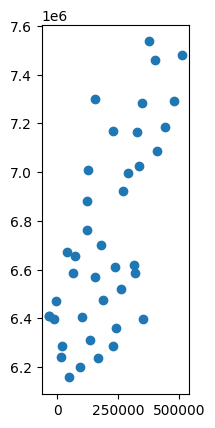

In [186]:
pos.plot()

    There are too many airports, lets cut the less important ones.

<AxesSubplot: >

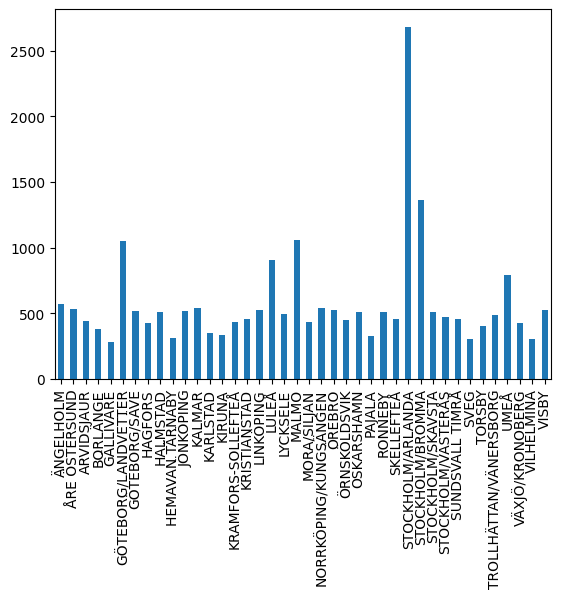

In [187]:
df.sum().plot(kind='bar')

Lets cut the smallest for ease of computations

In [188]:
# idx = df.sum().nsmallest(30).index.tolist()

# df = df.drop(idx, axis=1)
# df = df.drop(idx, axis=0)

# gdf = gdf.drop(idx, axis=1)
# gdf = gdf.drop(idx, axis=0)

# pos = pos.drop(idx, axis=0)
# pos.plot()

#bbox = Polygon([(-74.03356825, 45.212631402221),(-73.33044325, 45.212631402221),(-73.33044325, 45.774700697779),(-74.03356825, 45.774700697779),(-74.03356825, 45.212631402221)])

bbox = Polygon([(0, 6586150.253), (5000000, 6586150.253), (5000000 ,8460929.202),(0 ,8460929.202)])

#only two trips are outside the boundingbox: 826 and 3772
#we drop them immediately
airports = pos.loc[[x for x in pos.within(bbox).tolist()]].index.unique(level=0).tolist()
#gdf.drop(trips_outside, level=0, inplace=True)

<AxesSubplot: >

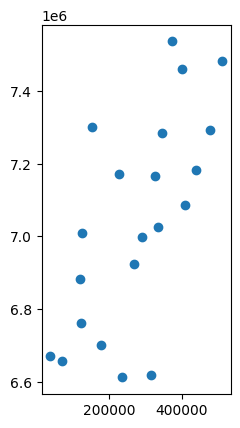

In [189]:
df = df.loc[airports][airports].copy()
gdf = gdf.loc[airports][airports].copy()
pos = pos.loc[airports].copy()

pos.plot()

In [190]:
planes_df = pd.read_csv('Data/Aircriaft_Cost_data.csv', delimiter=';', decimal=',', index_col=0, dtype={'cap':int, 'cost':float, 'max_dist':float, 'land_cost':float})
# max_dist is in km, convert to m
planes_df['max_dist'] = planes_df['max_dist']*1000


#add a zero plane:
zero_plane = pd.DataFrame(index=["noplane"])
zero_plane["cap"] = 0
zero_plane["cost"] = 0
zero_plane["max_dist"] = planes_df["max_dist"].max()
zero_plane["land_cost"] = 0
planes_df = pd.concat([zero_plane, planes_df], ignore_index=False)

planes_df

,cap,cost,max_dist,land_cost
noplane,0,0.0,2100000.0,0.0
AEA,30,15.0,200000.0,100.0
HEA,30,20.0,400000.0,100.0
Conventional,90,45.0,2100000.0,500.0


In [191]:
planes = [n for n in planes_df.index.tolist()]
nodes = [i for i in df.index.tolist()]


    
max_dist = planes_df["max_dist"].max()
for node in nodes:
    min_dist = gdf[node].astype(float).nsmallest(2).tolist()[-1]
    if min_dist > max_dist:
        print(node, "is to far away from the system")
        

arcs = [(i,j) for i in nodes for j in nodes if i!=j] #check all arcs
D_ij = {} #length of arc i,j
N_ij = {} #planes available between i and j
poss_arcs = [] #only use possible arcs
for tup in arcs:
    dist_ij = gdf[tup[0]][tup[1]] #length of arc
    n_list = []
    for plane in planes: #check if there are any planes that 
        if planes_df["max_dist"][plane]>dist_ij:
            n_list.append(plane)
    if len(n_list) > 0:
        poss_arcs.append(tup)
        D_ij[tup] = dist_ij
        N_ij[tup] = n_list

all_arcs = arcs
arcs = poss_arcs #only use possible arcs

commodities = [h for h in nodes]
W_h_i = {} #demand of commodity h at node i

for node in nodes:
    com = node
    total_flow_in = df[node].sum()
    W_h_i[(com, node)] = -total_flow_in
    
    for com in nodes:
        if com != node:
            flow_out = df[node][com]
            W_h_i[(com,node)] = flow_out


K_n = {}
C_n = {}
Cl_n = {}
for plane in planes:
    K_n[plane] = planes_df["cap"][plane]
    C_n[plane] = planes_df["cost"][plane]
    Cl_n[plane] = planes_df["land_cost"][plane]


arc_plane_n_ij = [(n,i,j) for (i,j) in arcs for n in N_ij[(i,j)]]

C_n_ij = {}
for (n,i,j) in arc_plane_n_ij:
    C_n_ij[(n,i,j)] = C_n[n]*D_ij[(i,j)]


CN_ij = {} #continous cost
KN_ij = {} #
Cl_N = {}
for arc in arcs:
    if len(N_ij[arc])>0:
        plane = N_ij[arc][-1]
        KN_ij[arc] = K_n[plane]
        P_N = C_n[plane]*D_ij[arc]
        CN_ij[arc] = P_N
        Cl_N[arc] = planes_df["land_cost"][plane]
    else:
        KN_ij[arc] = 0
        CN_ij[arc] = 0
        Cl_N[arc] = 0



M = 0
for node in nodes:
    od = df[node].sum()
    M += od
    
M = np.ceil(M) + 1 #np.ceil(M/planes_df["cap"].max()) + 1  #max(max(KN_ij.values()), M) + 1

M_low = np.ceil(M/planes_df["cap"].max()) + 1  #max(max(KN_ij.values()), M) + 1


In [192]:
#model
try:
    m = gp.Model("airfleet")
    
    ###Variables:
    
    
    # Create variables
    f = m.addVars(commodities, arcs, name="F")
    g = m.addVars(arcs, vtype=GRB.BINARY, name="G") 
    a = m.addVars(arc_plane_n_ij, vtype=GRB.BINARY, name="A")
    ag = m.addVars(arcs, ub=M_low, vtype=GRB.INTEGER, name="AG")
    #u = m.addVars(arcs, name="U")
    #u_help = m.addVars(arcs, lb=-M, name="U_help")
    f_arc = m.addVars(arcs, name = "farc")
    #z_help = m.addVars(arcs, name="z_help") 
    #hub_help = m.addVars(nodes, name="hub_help")
    #hub = m.addVars(nodes, vtype=GRB.BINARY, name="hub")
    
    obj = a.prod(C_n_ij) + ag.prod(CN_ij) + ag.prod(Cl_N) + sum(sum(Cl_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs) 
    
    
    #Objective function (a)
    m.setObjective(obj, GRB.MINIMIZE)

    # Flow-conservation constraints
    m.addConstrs(
        (f.sum(h, '*', i) + W_h_i[h, i] == f.sum(h, i, '*')
         for h in commodities for i in nodes), "node")
    
    #F assign total flow on arc
    m.addConstrs((f_arc[i,j] == f.sum("*", i, j) for (i,j) in arcs), "H")

    
    #G see if we use more than one plane:
    m.addConstrs((g[i,j]*M >= f_arc[i,j] - KN_ij[(i,j)] for (i,j) in arcs), "8a")    # g=1 if flow> max capacity
    m.addConstrs(((1-g[i,j])*M >= KN_ij[(i,j)]- f_arc[i,j] for (i,j) in arcs), "8b") # g=0 if flow < max capacity
    
    #A pick a plane
    m.addConstrs((f_arc[i,j] <= sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) + KN_ij[i,j]*ag[i,j] for (i,j) in arcs), "9b") # ensure flow < capacity of the chosen plane
    m.addConstrs((sum(a[n,i,j] for n in N_ij[(i,j)]) + g[i,j] == 1 for (i,j) in arcs), "9a") # pick ONE plane OR pick ag
    
    
    m.addConstrs(M_low*g[i,j] >= ag[i,j] for (i,j) in arcs) #ensure that if you pick ag, then g = 1 
    m.addConstrs(M_low*(1-g[i,j]) >= -ag[i,j] + 0.0001 for (i,j) in arcs) #else 0
    
    #fly the plane back
    #this will become infeasible when symmetry is not ensured
    m.addConstrs(a[n,i,j] == a[n,j,i] for (n,i,j) in arc_plane_n_ij)
    m.addConstrs(ag[i,j] == ag[j,i] for (i,j) in arcs)
    
    
    
    #U calculate how much flow should be covered by "plane g", i.e. with continous flow (all or nothing)
    #m.addConstrs((u_help[i,j] == f_arc[i,j] - sum(K_n[n]*a[n,i,j] for n in N_ij[(i,j)]) for (i,j) in arcs), "10") 
    #for i,j in arcs:
    #    m.addConstr((u[i,j] == gp.max_(u_help[i,j], constant=0))) # u = 0 if a plane "a" was chosen
                                                                  # u = f_arc if "g" was chosen 

    #HUB 
    # keep track of which arcs are being used
    #m.addConstrs((z_help[i,j] == sum(a[n,i,j] for n in N_ij[(i,j)][1::]) for (i,j) in arcs), "10")  # if a plane besides "noplane" or was chosen
                                                                                                    # this arc is being used
    # compute the total amount of arcs going into and out of each node
    #m.addConstrs((hub_help[i] == z_help.sum(i,"*") + z_help.sum("*",i) for i in nodes), "12a")
    
    # assign hub-status
    #M_nodes = (len(nodes) + 1)*2 # Just a value that will always be higher than hub_help
    #m.addConstrs((hub[i]*M_nodes >= hub_help[i]-2  for i in nodes), "12b")             # if "nodes in and out" > 2, hub=1
    #m.addConstrs(((1-hub[i])*M_nodes >= 2-hub_help[i] + 0.001 for i in nodes), "12c")  # if "nodes in and out" <= 2, hub=0
    
    m.setParam('MIPGap', 0.05)
    m.optimize()
    #for v in m.getVars():
    #    print('%s %g' % (v.VarName, v.X))
    
    print('Obj: %g' % m.ObjVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4969 rows, 11248 columns and 36592 nonzeros
Model fingerprint: 0x795ef149
Variable types: 9240 continuous, 2008 integer (1588 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+03]
  Objective range  [5e+05, 4e+07]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e+00, 7e+03]
Presolve removed 2218 rows and 1261 columns
Presolve time: 0.18s
Presolved: 2751 rows, 9987 columns, 31665 nonzeros
Variable types: 9240 continuous, 747 integer (537 binary)
Found heuristic solution: objective 5.584142e+09

Root relaxation: objective 1.457651e+09, 8498 iterations, 2.01 seconds (1.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1.4577e+09    0  168 5.5841e+09 1.4577e+

In [193]:
# retrieve hubs
# z_s = np.array(m.getAttr("X", z.values())).reshape((n_nodes,n_nodes))
# z_s = z_s.round(1)

# find value True for each row (representing the corresponding hub)
# gdf["hub"] = np.argmax(z_s, axis=1) == range(n_nodes)

# retrieve flow solution
f_arc_s = m.getAttr("X", f_arc)

# retrieve which legs are flown by which plane
a_s = m.getAttr("X", a)
a_sd = {(o, d): plane for (plane, o, d), v in a_s.items() if v != 0}
g_s = m.getAttr("X", g)
g_sd = {k: "over" for k, v in g_s.items() if v != 0}

# note that the legs are not always doable by the plane, so we need to check that before counting the number of legs by planes
planes_leg = {**a_sd, **g_sd}

In [194]:
i = 0

flow_dic = {}
hub_dic = {}
for node in df.index.tolist():
    flow_dic[node] = 0
    hub_dic[node] = 0

for key, val in m.getAttr("X", f).items():
    com = key[0]
    nod0 = key[1]
    nod1 = key[2]
    if com != nod1:
        flow_dic[nod1] += val
        if val > 1:
            try:
                plane = a_sd[nod0,nod1]
            except:
                plane = planes[-1]
#            if com==nod0:
#                print(key, val)
            if plane == planes[-1]:
                hub_dic[nod1] +=1
pos["fin_flow"] = flow_dic.values()

pos["hub"] = hub_dic.values()
pos["hub"] = pos["hub"] >= 1

In [195]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


<AxesSubplot: >

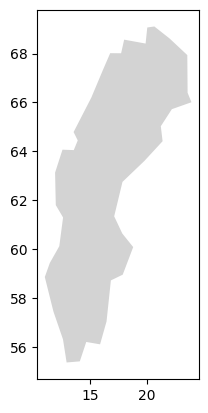

In [196]:
countries[countries["name"] == "Sweden"].plot(color="lightgrey")

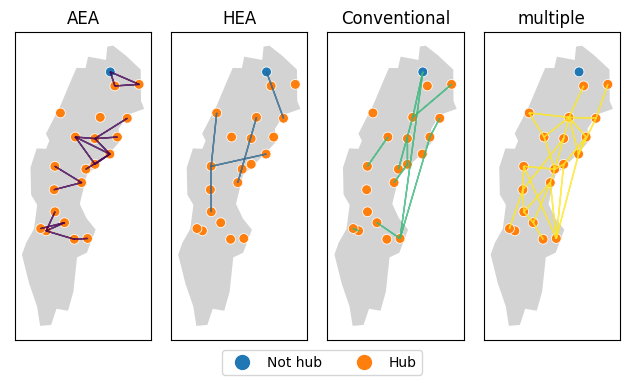

In [197]:
coords = pd.read_csv('Data/Name_Coordinates_NEW.csv', delimiter=';', index_col=0)
coords = coords.rename(columns={'Coordinates':'geometry'})
coords["geometry"] = coords["geometry"].apply(wkt.loads)
coords = gpd.GeoDataFrame(coords, geometry='geometry')

fig, ax = plt.subplots(1, len(planes))

for ax, plane in zip(ax.flat, planes[1:] + ['over']):
    countries[countries["name"] == "Sweden"].plot(color="lightgrey", ax=ax)
    # Plot nodes with edges with the hubs
    # pick standard matplotlib colors, so orange and green for true/false
    
    sns.scatterplot(x=coords["geometry"].x, y=coords["geometry"].y, legend=False, s=50, hue=pos['hub'], ax=ax, palette={True:'C1', False:'C0'}, )
    # for i, point in pos.iterrows():
    #     ax.text(point["geometry"].x +.02, point["geometry"].y + 0.02, str(i))
        

    # Now connect the legs with lines
    cmap = plt.get_cmap('viridis', len(planes))
    colors = cmap(np.linspace(0, 1, len(planes)))
    p_to_c = {p:c for p,c in zip(planes[1:] + ['over'], colors)}

    for p,q in arcs:
        if planes_leg[p,q] == plane:
            ax.arrow(coords.geometry[p].x, coords.geometry[p].y, coords.geometry[q].x - coords.geometry[p].x, coords.geometry[q].y - coords.geometry[p].y, width=0.005, length_includes_head=True, color=p_to_c[planes_leg[p,q]], alpha=0.5)
    
    if plane == 'over':
        plane = 'multiple'
    ax.set_title(plane)
    
    x_lo, x_up = ax.get_xlim()
    y_lo, y_up = ax.get_ylim()
    
    ax.set_xlim(x_lo - 0.1, x_up + 0.1)
    ax.set_ylim(y_lo, y_up)

    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()
# legend for the colors as circular patches for hub or not hub
patches = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color='C0', label="Not hub" )[0],
           plt.plot([],[], marker="o", ms=10, ls="", mec=None, color='C1', label="Hub" )[0]]
plt.legend(handles=patches, bbox_to_anchor=(-0.4, -0.01), ncol=2)

In [198]:
# count the number of legs by plane
legs_by_plane = {plane:0 for plane in planes+["over"]}
for p,q in arcs:
    legs_by_plane[planes_leg[p,q]] += 1/2
legs_by_plane

{'noplane': 147.0, 'AEA': 18.0, 'HEA': 5.0, 'Conventional': 11.0, 'over': 29.0}